### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [45]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain.vectorstores import FAISS
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains import RetrievalQA
from langchain.docstore.document import Document
from transformers import pipeline

In [ ]:
from google.colab import files
files.upload()  

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Load the Dataset

In [6]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("cynthiarempel/amazon-us-customer-reviews-dataset")

print("Path to dataset files:", path)

100%|██████████| 21.0G/21.0G [03:47<00:00, 99.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cynthiarempel/amazon-us-customer-reviews-dataset/versions/9


In [8]:
!ls ~/.kaggle

kaggle.json


In [11]:
print(path)
os.listdir(path)

/root/.cache/kagglehub/datasets/cynthiarempel/amazon-us-customer-reviews-dataset/versions/9


['amazon_reviews_us_Video_Games_v1_00.tsv',
 'amazon_reviews_us_Wireless_v1_00.tsv',
 'amazon_reviews_us_Shoes_v1_00.tsv',
 'amazon_reviews_us_Toys_v1_00.tsv',
 'amazon_reviews_us_Apparel_v1_00.tsv',
 'amazon_reviews_us_Automotive_v1_00.tsv',
 'amazon_reviews_us_Electronics_v1_00.tsv',
 'amazon_reviews_us_Musical_Instruments_v1_00.tsv',
 'amazon_reviews_us_Video_v1_00.tsv',
 'amazon_reviews_us_Sports_v1_00.tsv',
 'amazon_reviews_us_Mobile_Apps_v1_00.tsv',
 'amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv',
 'amazon_reviews_us_Grocery_v1_00.tsv',
 'amazon_reviews_us_Furniture_v1_00.tsv',
 'amazon_reviews_us_Major_Appliances_v1_00.tsv',
 'amazon_reviews_multilingual_US_v1_00.tsv',
 'amazon_reviews_us_Beauty_v1_00.tsv',
 'amazon_reviews_us_Software_v1_00.tsv',
 'amazon_reviews_us_Mobile_Electronics_v1_00.tsv',
 'amazon_reviews_us_Health_Personal_Care_v1_00.tsv',
 'amazon_reviews_us_Tools_v1_00.tsv',
 'amazon_reviews_us_Music_v1_00.tsv',
 'amazon_reviews_us_Outdoors_v1_00.tsv',
 'amazon

In [17]:
!cp "/root/.cache/kagglehub/datasets/cynthiarempel/amazon-us-customer-reviews-dataset/versions/9/amazon_reviews_us_Electronics_v1_00.tsv" /content/

### Exploratory Data Analysis (EDA)

In [19]:
df = pd.read_csv("/content/amazon_reviews_us_Electronics_v1_00.tsv", sep='\t',on_bad_lines='skip')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [21]:
df = df[['product_id','product_title', 'product_category','star_rating', 'review_body']]

In [22]:
df.head()

,product_id,product_title,product_category,star_rating,review_body
0,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,As described.
1,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,It works as advertising.
2,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,Works pissa
3,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,Did not work at all.
4,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,Works well. Bass is somewhat lacking but is pr...


In [23]:
df =  df.drop('product_category', axis=1)

In [24]:
df.isna().sum()

,0
product_id,0
product_title,4
star_rating,0
review_body,147


In [25]:
df = df.dropna()


In [26]:
df = df.head(2000)
print("Dataset shape:", df.shape)

Dataset shape: (2000, 4)


/tmp/ipython-input-3471614533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='star_rating', data=df, palette = 'magma')


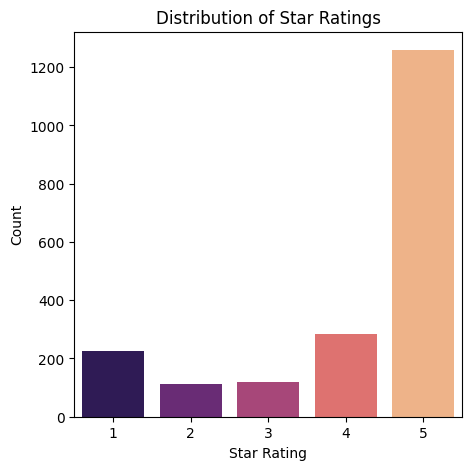

In [27]:
plt.figure(figsize=(5, 5))
sns.countplot(x='star_rating', data=df, palette = 'magma')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

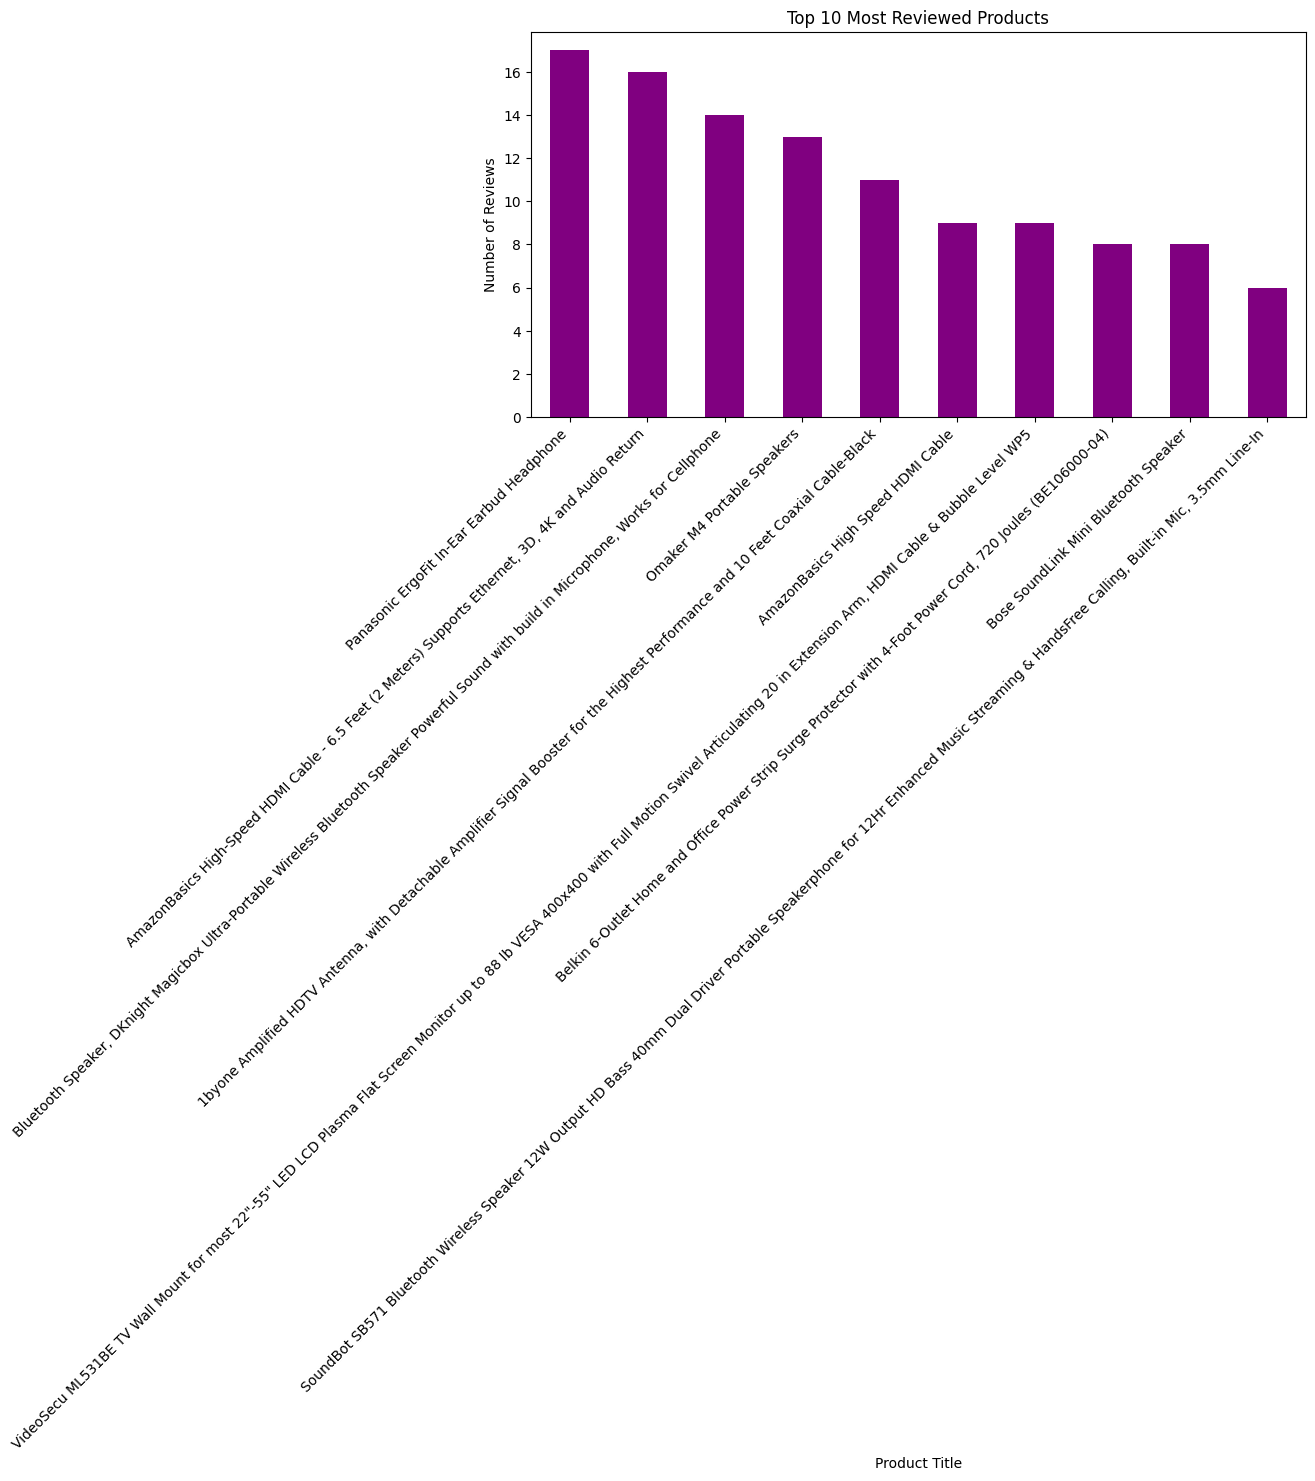

In [28]:
top_products = df['product_title'].value_counts().head(10)
plt.figure(figsize=(10, 5))
top_products.plot(kind='bar', color='purple')

plt.title('Top 10 Most Reviewed Products')
plt.xlabel('Product Title')
plt.ylabel('Number of Reviews')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

### Preprocessing the data

In [29]:
# Combine product title and review into a single text field
df['combined_text'] = df.apply(
    lambda row: f"Product: {row['product_title']} | Rating: {row['star_rating']} | Review: {row['review_body']}",
    axis=1
)

In [30]:
pd.set_option('display.max_colwidth', 1000)

In [31]:
df['combined_text'].head()

,combined_text
0,Product: yoomall 5M Antenna WIFI RP-SMA Female to Male Extensionl Cable | Rating: 5 | Review: As described.
1,"Product: Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor | Rating: 5 | Review: It works as advertising."
2,Product: Channel Master Titan 2 Antenna Preamplifier | Rating: 5 | Review: Works pissa
3,Product: LIMTECH Wall charger + USB Hotsync & Charging Dock Cradle desktop Charger for Apple IPOD Shuffle 2nd Generation MP3 Player | Rating: 1 | Review: Did not work at all.
4,Product: Skullcandy Air Raid Portable Bluetooth Speaker | Rating: 5 | Review: Works well. Bass is somewhat lacking but is present. Overall pleased with the item.


In [37]:
# Transform dataframe rows into document objects
# Convert to LangChain Documents (Fixed: use row["combined_text"])
documents = [Document(page_content=row["combined_text"], metadata={"product_id": row["product_id"], "star_rating": row["star_rating"]})
             for _, row in df.iterrows()]

In [38]:
# Split text into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = text_splitter.split_documents(documents)

In [42]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(split_docs, embedding_model)

### Set Up the LLM

In [46]:
# Set up a local LLM pipeline
llm_pipeline = pipeline("text-generation", model="distilgpt2", max_new_tokens=100)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

# Define the RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(search_kwargs={"k": 2}),  # Retrieve top 2 matches
    return_source_documents=True
)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipython-input-2122694819.py:3: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=llm_pipeline)


In [48]:
def get_recommendation(query):
    # Run the query through the RAG chain
    result = qa_chain({"query": query})
    retrieved_docs = result["source_documents"]
    generated_text = result["result"]

    # Debug: Print retrieved documents
    print("Retrieved Documents:")
    for i, doc in enumerate(retrieved_docs, 1):
        print(f"{i}. {doc.page_content[:100]}... | Rating: {doc.metadata['star_rating']}")

    # Filter by price and rating if specified
    max_price = None
    min_rating = 4  # Default to recommending 4+ star products
    if "under $" in query.lower():
        try:
            max_price = float(query.lower().split("under $")[1].split()[0])
            print(f"Filtering for max price: ${max_price}")
        except:
            pass
    if "rating" in query.lower():
        try:
            min_rating = float(query.lower().split("rating")[1].split()[0])
            print(f"Filtering for min rating: {min_rating}")
        except:
            pass

    # Extract relevant products
    recommended_products = []
    for doc in retrieved_docs:
        rating = doc.metadata["star_rating"]
        if rating >= min_rating:
            recommended_products.append({
                "product_id": doc.metadata["product_id"],
                "text": doc.page_content
            })

    # Craft a response with more detail
    if recommended_products:
        response = "Here are my recommendations based on your request:\n"
        for i, prod in enumerate(recommended_products, 1):
            response += f"{i}. {prod['text']}\n"
        response += f"\nAdditional Info: {generated_text}"
    else:
        response = "Sorry, no products match your criteria.\n"
        response += "Possible reasons:\n"
        response += "- The dataset subset may lack suitable laptops matching 'durable'.\n"
        response += "Check the retrieved documents above for details."

    return response

# Test the chatbot
query = "Suggest a durable laptop with rating 4 or higher"
response = get_recommendation(query)
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Retrieved Documents:
1. Product: Elite Screens Manual Screen | Rating: 5 | Review: Beautiful screen, fast shipping! Very ple... | Rating: 5
2. Product: AC adapter battery charger for Dell Inspiron 6000 6000D 600M 630M 6400 640M Series Laptop b... | Rating: 4
Filtering for min rating: 4.0
Here are my recommendations based on your request:
1. Product: Elite Screens Manual Screen | Rating: 5 | Review: Beautiful screen, fast shipping! Very pleased!
2. Product: AC adapter battery charger for Dell Inspiron 6000 6000D 600M 630M 6400 640M Series Laptop by sunvalleytek | Rating: 4 | Review: OKAY!!!

Additional Info: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Product: Elite Screens Manual Screen | Rating: 5 | Review: Beautiful screen, fast shipping! Very pleased!

Product: AC adapter battery charger for Dell Inspiron 6000 6000D 600M 630M 6400 640M Series Laptop by sunvalleytek